In [1]:
import os
import numpy as np
import torch
import pickle
import time
import sys

current_directory = os.getcwd()
models_dir = os.path.join(current_directory, '..')
print(models_dir)
sys.path.append(models_dir)

import torch
from notebook_utils import *
from torch.utils.data import DataLoader, Dataset
from models import Pose2AudioTransformer, Dance2MusicDiffusion
from transformers import EncodecModel
from utils import DanceToMusic
from datetime import datetime
from torch.optim import Adam

/home/azeez/Documents/projects/DanceToMusicApp/ml/notebooks/..


/home/azeez/anaconda3/envs/dance2music/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# assign GPU or CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device = torch.device("cpu")

model_id = "facebook/encodec_24khz"
encodec_model = EncodecModel.from_pretrained(model_id)
encodec_model.to(device)
codebook_size = encodec_model.quantizer.codebook_size
sample_rate = 24000

config = "/home/azeez/Documents/projects/my_logs/run_20240306-104458/config_file/latent_diffusion.txt"
args = parse_args(config)
dataset = DanceToMusic(args.data_dir, encoder = encodec_model, sample_rate = sample_rate, device=device, clean_poses=True, 
                                movement_threshold= args.movement_threshold, keypoints_threshold = args.keypoints_threshold, frame_error_rate = args.frame_error_rate)
print(f"Length of dataset: {len(dataset)}")

/home/azeez/anaconda3/envs/dance2music/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Length of dataset: 832


In [3]:
target_shape = dataset.data['audio_codes'][0].shape
pose_seq_len = dataset.data['poses'].shape[1]
weights_path = "/home/azeez/Documents/projects/my_logs/run_20240229-214411_1_34days/model_saves_and_validation_samples/epoch_836/ld_3_sec_dnb__loss_0.6419.pt"
weights_path = "/home/azeez/Documents/projects/my_logs/run_20240306-104458/model_saves_and_validation_samples/epoch_861/ld_3_sec_dnb__loss_1.5901.pt"
ld_model = Dance2MusicDiffusion(c_in = 64, c_out = 64, pose_seq_len = pose_seq_len, num_labels = codebook_size, blocks=[3, 6, 3], c_cond=256)
ld_model.to(device)
# load weights from a pre-trained model on cpu 
ld_model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
total_params_encodec = sum(p.numel() for p in encodec_model.parameters())
print(f"Total parameters in encodec model: {total_params_encodec}")

total_params_ld = sum(p.numel() for p in ld_model.parameters())
print(f"Total parameters in ld model: {total_params_ld}")

Total parameters in encodec model: 14851810
Total parameters in ld model: 394158272


In [12]:
def sample_from_ld_model(ld_model, pose_sequence, size = [226,2], num_samples=1, device='cpu'):
    """
    Sample audio codes from the Dance2MusicDiffusion model.

    Args:
    - ld_model: The Dance2MusicDiffusion model instance.
    - pose_sequence: The pose sequence tensor for conditioning.
    - num_samples: Number of samples to generate.
    - device: Device to run the model on ('cuda' or 'cpu').

    Returns:
    - sampled_audio_codes: Tensor of sampled audio codes.
    """
    ld_model.eval()  # Set the model to evaluation mode
    pose_sequence = pose_sequence.to(device)

    # Generate a random tensor of the same shape as audio_codes
    random_audio_codes = torch.randint(0, ld_model.num_labels, (num_samples, *size)).to(device)

    # No noise is added for inference, t is set to zero
    t = torch.zeros(num_samples, device=device)
    print(f"Random audio codes shape: {random_audio_codes.shape}")
    print(f"t shape: {t.shape}")
    print(f"pose sequence shape: {pose_sequence.shape}")

    # Forward pass through the model
    _, log_probabilities = ld_model(random_audio_codes, t, pose_sequence)
    print(f"log_probabilities shape: {log_probabilities.shape}")

    # Sample from the probabilities
    sampled_audio_codes = torch.argmax(log_probabilities, dim=1)

    return sampled_audio_codes, log_probabilities

# Example usage
n = 100  # Index of the sample in the dataset
audio_codes, pose_sequence, pose_mask, wav, wav_mask, wav_path, vid_path, _ = dataset[n]
N, _, _ = pose_sequence.shape
context = pose_sequence.view(N, -1).to(device)
print(context.shape)
generated_audio_codes, log_probs = sample_from_ld_model(ld_model, context.unsqueeze(0), device=device)

print(f"Generated audio codes shape: {generated_audio_codes.shape}")

torch.Size([72, 96])
Random audio codes shape: torch.Size([1, 226, 2])
t shape: torch.Size([1])
pose sequence shape: torch.Size([1, 72, 96])
log_probabilities shape: torch.Size([1, 1024, 224, 2])
Generated audio codes shape: torch.Size([1, 224, 2])


In [13]:
def sample(model, model_inputs, latent_shape, unconditional_inputs=None, steps=12, renoise_steps=11, temperature=(1.0, 0.2), cfg=8.0, t_start=1.0, t_end=0.0, device="cuda"):
    with torch.inference_mode():
        sampled = torch.randint(0, model.num_labels, size=latent_shape, device=device)
        init_noise = sampled.clone()
        t_list = torch.linspace(t_start, t_end, steps+1)
        temperatures = torch.linspace(temperature[0], temperature[1], steps)
        for i, t in enumerate(t_list[:steps]):
            t = torch.ones(latent_shape[0], device=device) * t

            logits, _ = model(sampled, t, **model_inputs)
            scores = logits.div(temperatures[i]).softmax(dim=1)

            sampled = scores.permute(0, 2, 3, 1).reshape(-1, logits.size(1))
            sampled = torch.multinomial(sampled, 1)[:, 0].view(logits.size(0), *logits.shape[2:])

            if i < renoise_steps:
                t_next = torch.ones(latent_shape[0], device=device) * t_list[i+1]
                # print the size of the first dimenesion of the tensors sampled, t_next and init_noise
                t_i = np.minimum(sampled.size(1), init_noise.size(1))
                sampled = model.add_noise(sampled[:,:t_i,:], t_next, random_x=init_noise[:,:t_i,:])[0]
    return sampled

generated_sample = sample(ld_model, {"pose_sequence": context.unsqueeze(0)}, [1, 226, 2], device=device)
print(f"Generated sample shape: {generated_sample.shape}")

Generated sample shape: torch.Size([1, 224, 2])


In [14]:
from IPython.display import Audio, display

def audioCodeToWav(audio_code, encodec_model, sample_rate = 24000):
    """
    Logs the gradients of a model's parameters.
    Parameters:
    - audio_code: The audio code. A latent representation built by the encodec.encoder and decoded into a .wav by the encodec.decoder.
    - encodec_model: The model for encoding wav files into audio codes and decoding audio codes into wav files.
    - sample_rate: The sample rate of the wav file.
    Returns:
    - combined_wav: The decoded audio code as a wav file.
    """
    batch_size = audio_code.shape[0]
    audio_code = audio_code.reshape(batch_size,1,2,int(audio_code.shape[1]))

    # Check if the devices of audio_code and encodec_model.decoder are the same
    if encodec_model.device != audio_code.device:
        raise ValueError("The device of encodec_model.decoder and audio_code must be the same.")
    device = audio_code.device

    decoded_wavs = []
    # Iterate through each frame in audio_code and decode them individually
    for i in range(audio_code.size(0)):
        single_audio_code = audio_code[i:i+1]  # Extracting a single frame
        single_wav = encodec_model.decode(single_audio_code.int(), [None])
        decoded_wavs.append(single_wav[0])

    # Concatenate the decoded audio samples into a single tensor
    # Use torch.stack if each wav sample has more than one dimension, else use torch.cat
    if decoded_wavs[0].ndim > 1:
        combined_wav = torch.stack(decoded_wavs, dim=0)
    else:
        combined_wav = torch.cat(decoded_wavs, dim=0)

    return combined_wav.squeeze(1).to(device)

In [15]:
print(torch.max(generated_sample), torch.min(generated_sample))

N = encodec_model.quantizer.codebook_size
print(f"Codebook size: {N}")
print(f"Max value in audio_code: {torch.max(generated_sample)}")

tensor(1023) tensor(0)
Codebook size: 1024
Max value in audio_code: 1023


In [16]:
print(generated_sample.shape)
generated_wav = audioCodeToWav(generated_audio_codes, encodec_model, sample_rate = 24000)
print(generated_wav.shape)
display(Audio(generated_wav[0].detach().to('cpu').numpy(), rate=24000))

torch.Size([1, 224, 2])
torch.Size([1, 1, 71680])


In [17]:
from IPython.display import Video

vid_path = wav_path.split('.')[0]+'_with_audio.mp4'
print(vid_path)
Video(vid_path)

/home/azeez/Documents/projects/DanceToMusicApp/ml/data/samples/3sec_24fps_dnb/youtube_links_25_9_sample/youtube_links_25_9_with_audio.mp4


In [18]:
from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip
import numpy as np
import soundfile as sf
from scipy.io import wavfile
import os

# Assuming `wav` is a PyTorch tensor with your new audio data
# and `vid_path` is the path to your original video file.

# Specify the path to save the output video and the temporary audio
generated_output_video = '../assets/sample_generated_audio_diffusion.mp4'
og_output_video = '../assets/sample_original.mp4'
temp_audio_dir = '../assets'
temp_audio_path = os.path.join(temp_audio_dir, 'generated_audio_diffusion.wav')

os.makedirs(temp_audio_dir, exist_ok=True)

wav_np = generated_wav[0].detach().cpu().numpy()
max_val = np.max(np.abs(wav_np))
normalized_wav = wav_np / max_val
scaled_wav = np.int16(normalized_wav * 32767)
wavfile.write(filename=temp_audio_path, rate=24000, data=scaled_wav.T)

# Save the original video clip to the assets folder 
original_video_clip = VideoFileClip(vid_path)
original_video_clip.write_videofile(og_output_video)

# Now create the video clip with the new audio
video_clip = VideoFileClip(vid_path)
new_audio_clip = AudioFileClip(temp_audio_path)

new_audio_clip = CompositeAudioClip([new_audio_clip])
video_clip.audio = new_audio_clip
video_clip.write_videofile(generated_output_video)

# Close the clips to release their resources
video_clip.close()
new_audio_clip.close()
original_video_clip.close()

# os.remove(temp_audio_path)

Video(generated_output_video)

Moviepy - Building video ../assets/sample_original.mp4.
MoviePy - Writing audio in sample_originalTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ../assets/sample_original.mp4



Moviepy - Done !
Moviepy - video ready ../assets/sample_original.mp4
Moviepy - Building video ../assets/sample_generated_audio.mp4.
MoviePy - Writing audio in sample_generated_audioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ../assets/sample_generated_audio.mp4



Moviepy - Done !
Moviepy - video ready ../assets/sample_generated_audio.mp4


### Compare Generated Wav to Target with Beat Onset Detection Network

In [28]:
from utils.beat_onset_detection.bod_model import *
from utils.beat_onset_detection.bod_music_processor import *

bod_model = convNet()
bod_model = bod_model.to(device)

if torch.cuda.is_available():
    bod_model.load_state_dict(torch.load('/home/azeez/Documents/projects/DanceToMusicApp/ml/utils/beat_onset_detection/don_model.pth'))
else:
    bod_model.load_state_dict(torch.load('/home/azeez/Documents/projects/DanceToMusicApp/ml/utils/beat_onset_detection/don_model.pth', map_location='cpu'))
min_length = min(generated_wav.shape[-1], wav.shape[-1])
# Compute beat scores
gen_spec = torch_fft_and_melscale(generated_wav[:,:min_length].squeeze(0))
ref_spec = torch_fft_and_melscale(wav[:,:min_length].squeeze(0))

print(f"Generated spec shape: {gen_spec.shape}")
print(f"Reference spec shape: {ref_spec.shape}")
inference_gen = bod_model.torch_infer(gen_spec.squeeze(1), device, minibatch=4192)
inference_ref = bod_model.torch_infer(ref_spec, device, minibatch=4192)

print(f"Inference gen shape: {inference_gen.shape}")
print(f"Inference ref shape: {inference_ref.shape}")

Generated spec shape: torch.Size([3, 1, 80, 141])
Reference spec shape: torch.Size([3, 80, 141])
Inference gen shape: torch.Size([126])
Inference ref shape: torch.Size([126])


torch.Size([1, 72000]) torch.Size([1, 1, 71680])


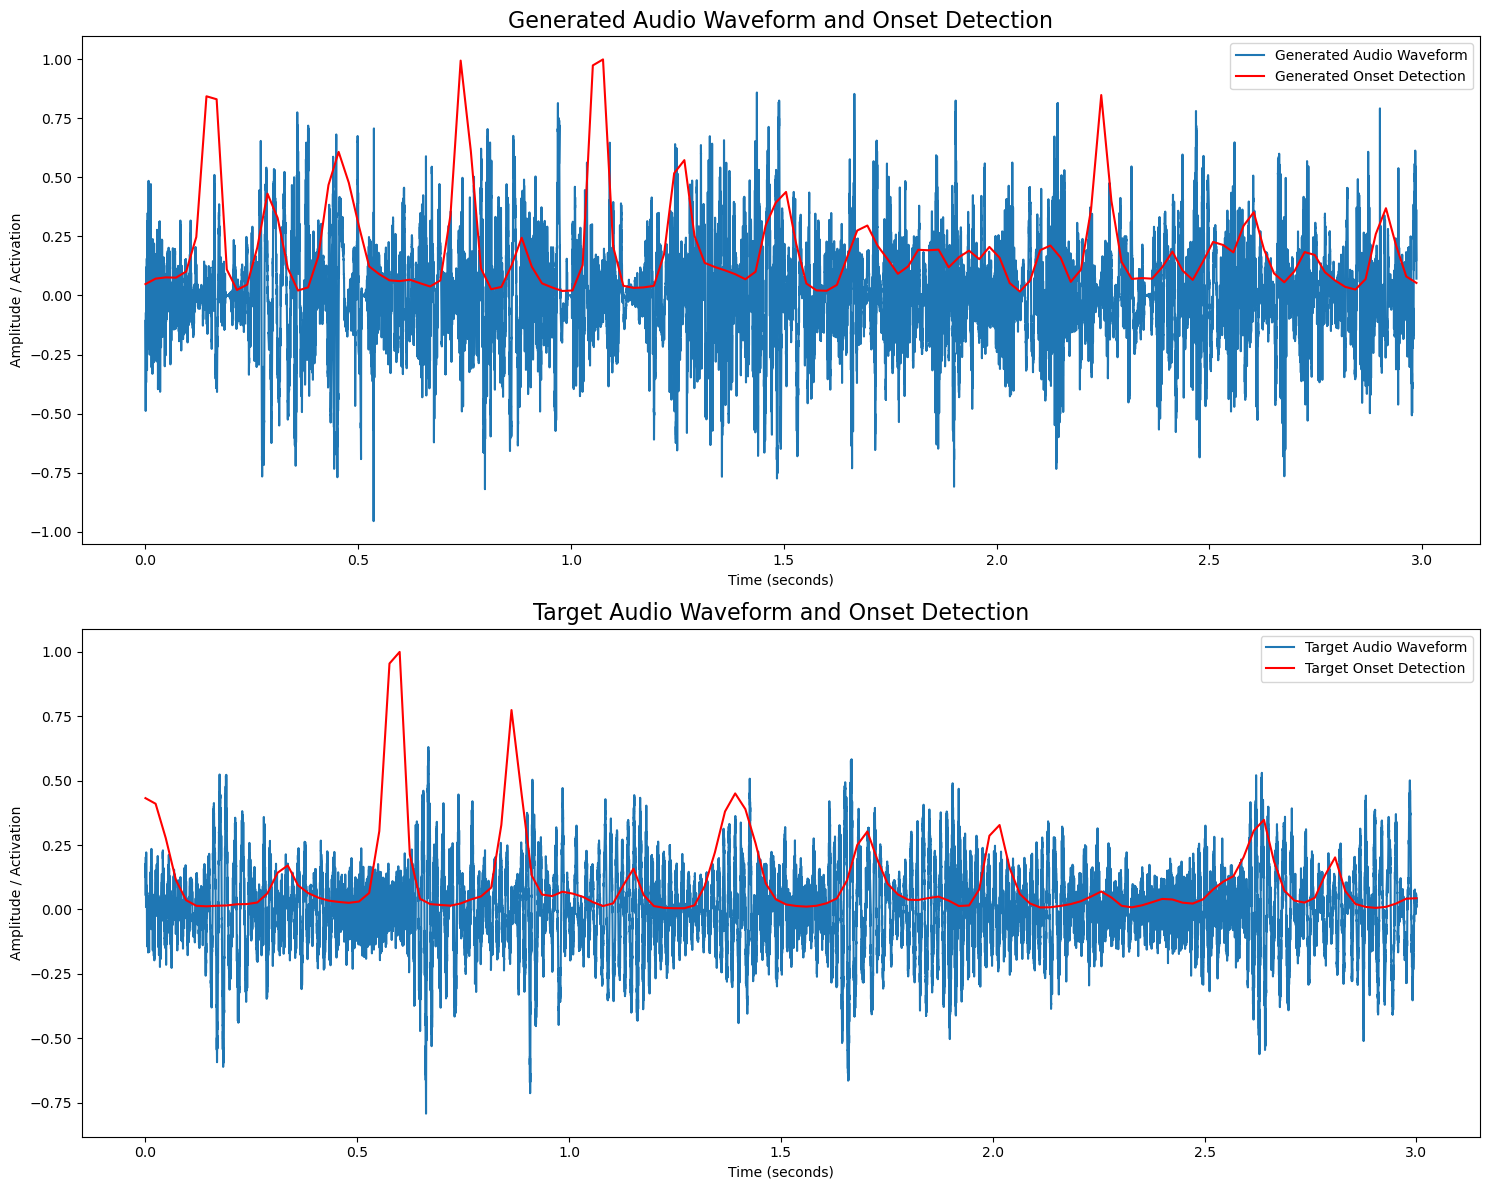

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your audio data and inferences: generated_wav, wav, inference_gen, inference_ref
audio_waveform_gen = generated_wav.squeeze(0).squeeze(0).detach().numpy()
print(wav.shape, generated_wav.shape)
audio_waveform_ref = wav.squeeze(0).detach().numpy()

np_inference_gen = inference_gen.numpy()
np_inference_ref = inference_ref.numpy()

sr = 24000  # Sample rate

# Normalize the inference results for better visualization
inference_normalized_gen = np_inference_gen / np.max(np_inference_gen)
inference_normalized_ref = np_inference_ref / np.max(np_inference_ref)

# Create time axis for the audio data
time_axis_gen = np.linspace(0, len(audio_waveform_gen) / sr, len(audio_waveform_gen))
time_axis_ref = np.linspace(0, len(audio_waveform_ref) / sr, len(audio_waveform_ref))

# Create corresponding time axes for the inference results
inference_time_axis_gen = np.linspace(0, len(audio_waveform_gen) / sr, len(np_inference_gen))
inference_time_axis_ref = np.linspace(0, len(audio_waveform_ref) / sr, len(np_inference_ref))

plt.figure(figsize=(15, 12))

# Plot for generated audio
plt.subplot(2, 1, 1)
plt.plot(time_axis_gen, audio_waveform_gen, label='Generated Audio Waveform')
plt.plot(inference_time_axis_gen, inference_normalized_gen, label='Generated Onset Detection', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude / Activation')
plt.title('Generated Audio Waveform and Onset Detection', fontsize=16)  # Larger title
plt.legend()

# Plot for Target audio
plt.subplot(2, 1, 2)
plt.plot(time_axis_ref, audio_waveform_ref, label='Target Audio Waveform')
plt.plot(inference_time_axis_ref, inference_normalized_ref, label='Target Onset Detection', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude / Activation')
plt.title('Target Audio Waveform and Onset Detection', fontsize=16)  # Larger title
plt.legend()

plt.tight_layout()
plt.show()
